# Übungszettel Nr. 10

__Abgabe von Kusurmann, Pape und Becker__
   

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(8)

## Aufgabe 29

In [2]:
epsilon = 0.23

In [3]:
def generate_A(dim, epsilon):
    A = np.zeros([dim, dim])

    np.fill_diagonal(A[1:], epsilon)
    np.fill_diagonal(A[:, 1:], epsilon)
    np.fill_diagonal(A, 1 - 2 * epsilon)
    
    A[0][0] = 1 - epsilon
    A[dim - 1][dim -1] = 1 - epsilon
    
    return A

### Aufgabenteil b)

In [4]:
f = np.array([193, 485, 664, 763, 804, 805, 779, 736, 684, 626,
             566, 508, 452, 400, 351, 308, 268, 233, 202, 173])

In [5]:
A = generate_A(len(f), epsilon)

In [6]:
g = A @ f

In [7]:
g_exp = np.zeros(len(g))

In [8]:
for i in range(len(g)):
    g_exp[i] = np.random.poisson(g[i])

### Aufgabenteil c)

Die neue Faltungsgleichung lautet: 

$$
g = \mathbf{UDU^{-1}}f
$$
Der Vorteil einer Transformation ist das wir nun $\mathbf{U}$ rüber zu $g$ packen können und auch 
$\mathbf{U}^{-1}$ mit f verwursten werden kann.

In [9]:
A_eval, A_evec = np.linalg.eig(A) #Eigenwerte, Eigenvektoren

In [10]:
eval_sort_index = np.argsort(np.abs(A_eval))[::-1]


Sortiere die Eigenwerte und Eigenvektoren

In [11]:
A_eval = A_eval[eval_sort_index]
A_evec = A_evec.T[eval_sort_index].T

A_eval

array([1.        , 0.99433664, 0.977486  , 0.949863  , 0.91214782,
       0.86526912, 0.81038122, 0.74883563, 0.68214782, 0.61195985,
       0.54      , 0.46804015, 0.39785218, 0.33116437, 0.26961878,
       0.21473088, 0.16785218, 0.130137  , 0.102514  , 0.08566336])

In [12]:
U = A_evec
D = np.diag(A_eval)

### Aufgabenteil d)

In [13]:
U_inv = np.linalg.inv(U)

In [14]:
c = U_inv @ g
b = U_inv @ f

cov = np.diag(g_exp)

cov_traf = U_inv @ cov @ U_inv.T

In [15]:
b_exp = np.linalg.inv(D) @ U_inv @ g_exp

In [16]:
b_exp = np.abs(b_exp / np.sqrt(g_exp))

In [17]:
index = range(len(b_exp))

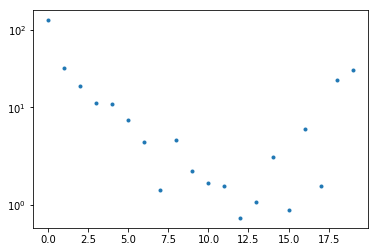

In [18]:
plt.plot(index, b_exp, '.')
plt.yscale('symlog')

### Aufgabenteil e)


In [19]:
b_exp = np.linalg.inv(D) @ U_inv @ g_exp

In [20]:
f_exp = U @ b_exp

In [21]:
b_exp[np.diagonal(D) < 0.3] = 0 
f_exp_reg = U @ b_exp

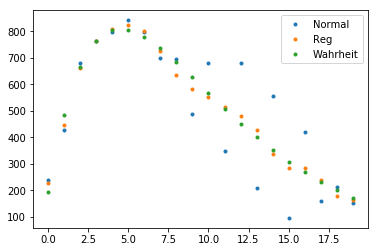

In [22]:
plt.plot(index, f_exp,'.', label='Normal')
plt.plot(index, f_exp_reg, '.', label='Reg')
plt.plot(index, f, '.', label='Wahrheit')

plt.legend()

## Aufgabe 30

In [23]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn import metrics

In [24]:
df = pd.read_hdf('./image_parameters_smd_reduced.hdf5')

In [25]:
labels = np.zeros(len(df['corsika_run_header_particle_id'].values))

In [26]:
labels[df['corsika_run_header_particle_id'].values ==1] = 1

In [27]:
df['Label'] = labels

In [28]:
center_of_gravity = df['concentration_cog'].values
center = df['concentration_core'].values

In [29]:
df_test = df 
df_test = df_test.drop(['run_id', 'event_num', 'corsika_run_header_particle_id', 'Label'], axis=1)
#for i in df_test:
 #   for j in df_test:
  #      if i != j:
   #         plt.scatter(df[i], df[j], c=labels, s=2, alpha=0.6, cmap='winter')
    #        plt.xlabel(i)
     #       plt.ylabel(j)
      #      plt.show()
       # else:
        #    pass

# Features: 
# concentration_cog
# photoncharge_shower_mean
# concentration_two_pixel
# leakage1
# size
# width
# photoncharge_shower_variance
# length
# skewness_long

In [30]:
df_features = df[['concentration_cog', 'photoncharge_shower_mean', 'concentration_two_pixel', 'leakage1', 'size', 'width', 'photoncharge_shower_variance', 'length', 'skewness_long', 'Label']]

Standatisiere erstmal meine ganzen Daten (https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/)

In [31]:
traningset, testset = train_test_split(df_features, test_size=0.2)

sc = StandardScaler()  
trainset_norm = sc.fit_transform(traningset.drop('Label', axis=1).values)

testset_norm = sc.transform(testset.drop('Label', axis=1).values)

### Aufgabenteil b)

Überprüfe wie viele $n_{estimators}$ benötigt werden.

In [32]:
for n_est in [1, 10, 100]:
    tree = RandomForestClassifier(n_estimators=n_est, random_state=0, max_depth=5)
    
    score = cross_validate(tree, trainset_norm, traningset['Label'],
                       scoring=metrics.make_scorer(metrics.roc_auc_score),
                       cv=5, n_jobs=4, return_train_score=True)
    
    print(f'n_estimators = {n_est}')
    print(f"Mean: {score['train_score'].mean():.2} +/- {score['train_score'].std():.2} ",'\n')

n_estimators = 1
Mean: 0.62 +/- 0.0048  

n_estimators = 10
Mean: 0.65 +/- 0.0019  

n_estimators = 100
Mean: 0.66 +/- 0.0011  



Es lohnt sich anscheinend 10 Bäume zu verwenden.
Traniere einen neuen Tree

In [33]:
clf = RandomForestClassifier(n_estimators=10, random_state=0, max_depth=5)

clf.fit(trainset_norm, traningset['Label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Prediction des Testdatensatzes

In [34]:
predicted_label = clf.predict(testset_norm)
predicted_label_score = clf.predict_proba(testset_norm)

Teste die Prediction

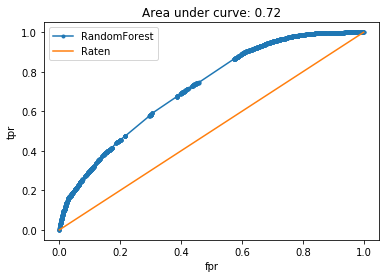

In [54]:
fpr, tpr, threshold = metrics.roc_curve(testset['Label'].values, predicted_label_score[:,1])

roc_score = metrics.roc_auc_score(testset['Label'].values, predicted_label_score[:,1])

x = np.linspace(0, 1, 100)

plt.plot(fpr, tpr, marker='.', label='RandomForest')
plt.plot(x, x, label = 'Raten')

plt.title(f'Area under curve: {roc_score:.2}')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()

In [52]:
print(metrics.classification_report(testset['Label'].values, predicted_label[:,1]))
print(metrics.accuracy_score(testset['Label'].values, predicted_label))

IndexError: too many indices for array

In [37]:
predicted_label_score.max(axis=1)

array([0.52998863, 0.51452784, 0.53628418, ..., 0.53174194, 0.52998863,
       0.53628418])

In [51]:
predicted_label_score[:,1]

array([0.52998863, 0.51452784, 0.53628418, ..., 0.53174194, 0.52998863,
       0.53628418])

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
        0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
        0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
        0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
        0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
        0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
        0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
        0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
        0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
        0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ]),
 <a list of 49 Patch objects>)

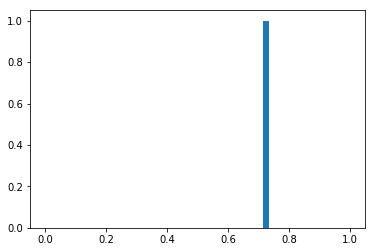

In [56]:
plt.hist(roc_score, bins=np.linspace(0, 1))

(array([ 662.,  493.,  653.,  618., 6262., 2039.,  917.,  356.,    0.]),
 array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 <a list of 9 Patch objects>)

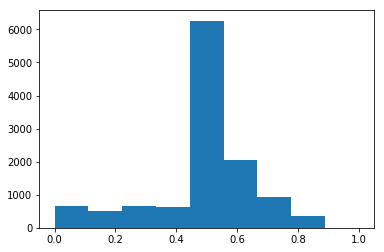

In [62]:
plt.hist(predicted_label_score[:,1], bins=np.linspace(0, 1, 10))